# Euro Coin Counter with A4 Reference

This notebook implements a coin value estimator using a single photo of coins
lying on an A4 sheet. The A4 paper serves as a geometric reference:

- We detect the sheet automatically.
- We rectify the view via homography.
- From the known A4 size (210 × 297 mm) we derive pixels per mm.
- We detect coins and classify them by diameter.


1. Introduction / problem description  
2. Imports and configuration  
3. Image loading and inspection  
4. A4 detection and homography  
5. Coin segmentation on rectified A4  
6. Feature extraction and classification  
7. Calibration and robustness discussion  
8. Pipeline summary / outlook


In [105]:
# ================================================================
# 1. Imports and basic setup
# ================================================================

from pathlib import Path
from dataclasses import dataclass

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["image.cmap"] = "gray"

def show(img, title: str = "", cmap=None):
    """
    Display an image using matplotlib.

    Parameters
    ----------
    img : np.ndarray
        Image to display. Can be grayscale (2D) or color (BGR).
    title : str, optional
        Title for the figure.
    cmap : str or None, optional
        Colormap for grayscale images. If None, uses default.
    """
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")


In [106]:
# ================================================================
# 2. Configuration
# ================================================================

DATA_DIR = Path("data")

# Example image (adjust to your filename)
IMAGE_PATH = DATA_DIR / "euros1_weird_shadowe.jpeg"

# A4 physical dimensions in millimetres (portrait)
A4_WIDTH_MM  = 210.0
A4_HEIGHT_MM = 297.0

# Desired sampling resolution of the rectified sheet
PIXELS_PER_MM = 3.0  # you can tune this

# Known Euro coin diameters in mm (approx.)
EURO_DIAMETERS_MM = {
    "1c": 16.25,
    "2c": 18.75,
    "5c": 21.25,
    "10c": 19.75,
    "20c": 22.25,
    "50c": 24.25,
    "1€": 23.25,
    "2€": 25.75,
}


## 3. Load and inspect input image


In [107]:
img_bgr = cv2.imread(str(IMAGE_PATH))
assert img_bgr is not None, "Image not found. Check IMAGE_PATH."

print("Original shape (H, W, C):", img_bgr.shape)
show(img_bgr, "Original image (BGR)")


AssertionError: Image not found. Check IMAGE_PATH.

## 4. A4 detection via contours
We detect the paper as the largest quadrilateral in the scene.


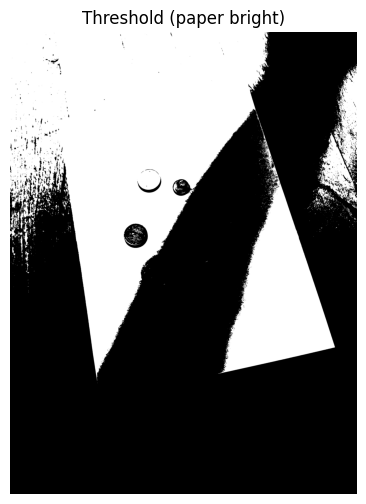

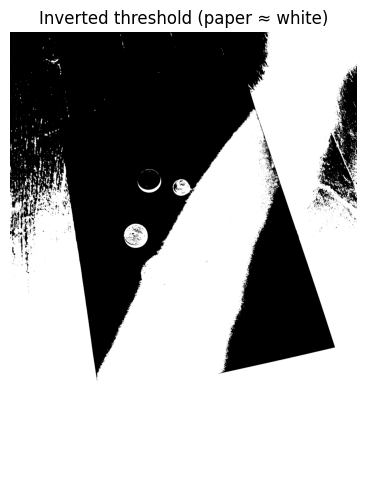

In [ ]:
# ================================================================
# 4. Robust A4 detection (largest bright rectangle)
# ================================================================

# 1) Grayscale + blur (you already have this)
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# 2) Global or Otsu threshold: paper is bright, table is darker
#    We invert so that paper ≈ white (255) and background ≈ 0.
_, th = cv2.threshold(
    blur, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
th_inv = cv2.bitwise_not(th)

show(th, "Threshold (paper bright)")
show(th_inv, "Inverted threshold (paper ≈ white)")


quad: [[3964. 1243.]
 [3821. 1848.]
 [4101. 2061.]
 [4256. 1910.]]


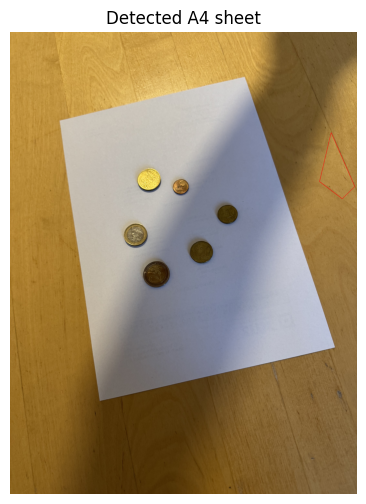

In [ ]:
def find_largest_quad_from_binary(bin_img: np.ndarray) -> np.ndarray | None:
    """
    Find the largest quadrilateral in a binary image.

    bin_img: binary image where the A4 paper is white (255) on black background.
    """
    h, w = bin_img.shape[:2]

    contours, _ = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    max_area = 0
    best_quad = None

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 5000:
            continue

        x, y, cw, ch = cv2.boundingRect(cnt)

        # skip things that touch the image border (likely background / artifacts)
        if x <= 0 or y <= 0 or x + cw >= w - 1 or y + ch >= h - 1:
            continue

        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        if len(approx) != 4 or not cv2.isContourConvex(approx):
            continue

        # aspect ratio filter (A4 ~ 0.7 or 1/0.7, depending on orientation)
        aspect = cw / ch
        if not (0.5 < aspect < 2.0):
            continue

        if area > max_area:
            max_area = area
            best_quad = approx

    if best_quad is None:
        return None

    return best_quad.reshape(-1, 2).astype(np.float32)


quad = find_largest_quad_from_binary(th)
print("quad:", quad)

img_debug = img_bgr.copy()
if quad is not None:
    cv2.polylines(img_debug, [quad.astype(int)], True, (0, 0, 255), 4)
show(img_debug, "Detected A4 sheet")



In [ ]:
def order_corners(pts: np.ndarray) -> np.ndarray:
    """
    Order 4 corner points to (top-left, top-right, bottom-right, bottom-left).

    Parameters
    ----------
    pts : np.ndarray
        Array of shape (4, 2).

    Returns
    -------
    ordered : np.ndarray
        Array of shape (4, 2) in the desired order.
    """
    assert pts.shape == (4, 2)

    # 1. sort by y-coordinate (ascending)
    pts_sorted = pts[np.argsort(pts[:, 1])]

    # first two are top row, last two are bottom row
    top = pts_sorted[:2]
    bottom = pts_sorted[2:]

    # 2. sort each row by x-coordinate
    top = top[np.argsort(top[:, 0])]
    bottom = bottom[np.argsort(bottom[:, 0])]

    tl, tr = top
    bl, br = bottom

    return np.array([tl, tr, br, bl], dtype=np.float32)


quad_ordered = order_corners(quad)
print("Ordered corners:\n", quad_ordered)



Ordered corners:
 [[3821. 1848.]
 [3964. 1243.]
 [4256. 1910.]
 [4101. 2061.]]


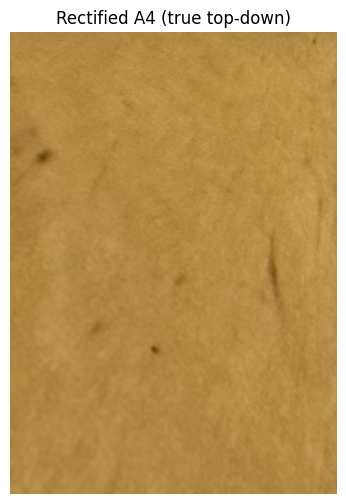

In [ ]:
rect_w_px = int(A4_WIDTH_MM  * PIXELS_PER_MM)
rect_h_px = int(A4_HEIGHT_MM * PIXELS_PER_MM)

dst_points = np.array([
    [0,             0],
    [rect_w_px - 1, 0],
    [rect_w_px - 1, rect_h_px - 1],
    [0,             rect_h_px - 1],
], dtype=np.float32)

H, _ = cv2.findHomography(quad_ordered, dst_points)

img_rect_bgr  = cv2.warpPerspective(img_bgr, H, (rect_w_px, rect_h_px))
img_rect_gray = cv2.cvtColor(img_rect_bgr, cv2.COLOR_BGR2GRAY)

show(img_rect_bgr, "Rectified A4 (true top-down)")


## 5. Coin segmentation (Step 1: Blur + Global Threshold)

We now work on the *rectified* A4 image. Coins appear as darker,
approximately circular objects on a bright sheet of paper.

In this first segmentation step we:

1. Apply a stronger Gaussian blur to the rectified grayscale image  
   → this suppresses small text and noise on the paper.
2. Apply a **global threshold** using Otsu's method  
   → this separates darker regions (coins) from the lighter background.

We intentionally keep this step simple and inspect the visual result
before adding any morphological operations or connected-component
analysis.


mask_otsu_step1 shape: (891, 630) dtype: uint8


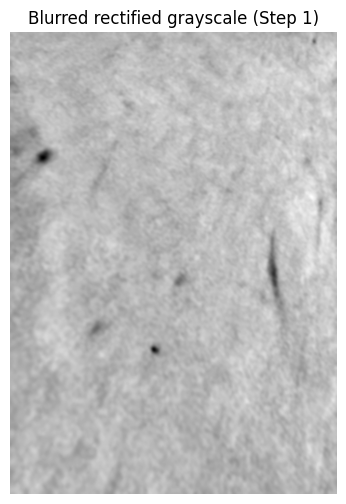

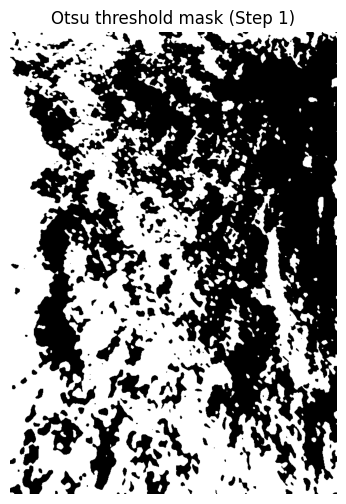

In [ ]:
# ================================================================
# 5. Coin segmentation (Step 1: blur + global Otsu threshold)
# ================================================================

import numpy as np
import cv2

def blur_and_threshold_otsu(img_gray: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Apply Gaussian blur and global Otsu threshold to the rectified
    grayscale image of the A4 sheet with coins.

    Parameters
    ----------
    img_gray : np.ndarray
        Rectified grayscale image (coins on A4 paper).

    Returns
    -------
    blur : np.ndarray
        Blurred version of the input image. The blur suppresses
        small details, such as text or paper texture.
    mask_otsu : np.ndarray
        Binary image (0 or 255) obtained by global Otsu thresholding
        on the blurred image. Since the coins are darker than the
        paper, we use `THRESH_BINARY_INV` so that coins become white
        (255) and the background becomes black (0).
    """
    # 1) Stronger blur to smooth out noise and faint text patterns
    blur = cv2.GaussianBlur(img_gray, (9, 9), 0)

    # 2) Global threshold with Otsu:
    #    - The threshold value is chosen automatically.
    #    - `THRESH_BINARY_INV` inverts the result so that
    #      dark regions (coins) turn into white blobs.
    _, mask_otsu = cv2.threshold(
        blur,
        0,
        255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    return blur, mask_otsu


# --- Run Step 1 on the rectified grayscale image ----------------
blur_step1, mask_otsu_step1 = blur_and_threshold_otsu(img_rect_gray)

show(blur_step1, "Blurred rectified grayscale (Step 1)")
show(mask_otsu_step1, "Otsu threshold mask (Step 1)")
print("mask_otsu_step1 shape:", mask_otsu_step1.shape, "dtype:", mask_otsu_step1.dtype)


### 5.2 Morphological refinement of the coin mask

The Otsu mask already separates the coins from the paper very well.
We still apply simple morphological operations to make the result
more robust:

1. **Opening** with a small structuring element  
   → removes tiny isolated pixels or very thin artifacts.
2. **Closing** with a slightly larger structuring element  
   → fills small gaps along the coin boundary and enforces solid discs.

After this step, each coin should appear as one clean, filled region.


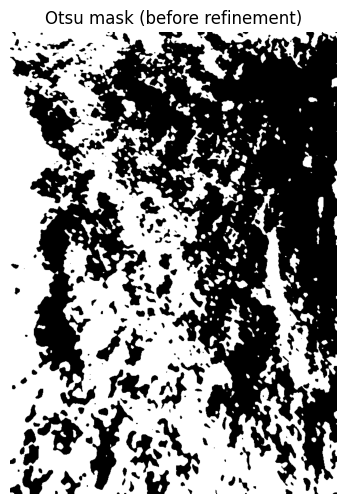

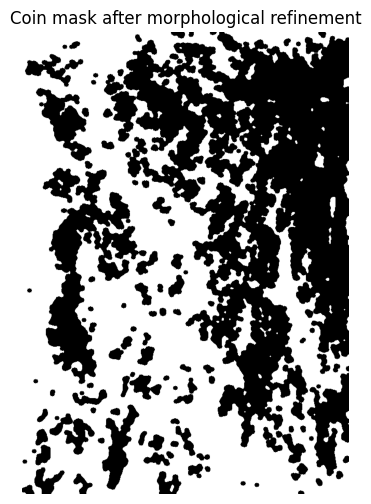

In [ ]:
# ================================================================
# 5.2 Morphological refinement of the coin mask
# ================================================================

def refine_coin_mask(mask: np.ndarray) -> np.ndarray:
    """
    Refine a binary coin mask using morphological operations.

    Parameters
    ----------
    mask : np.ndarray
        Binary image (0 or 255) where coins are white and background
        is black. Typically the output from the Otsu threshold step.

    Returns
    -------
    mask_refined : np.ndarray
        Binary image after morphological opening and closing.
        Ideally, each coin is represented by one solid, clean blob.
    """
    # Small kernel to remove tiny noise and smooth boundaries a bit
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # Larger kernel to close small gaps or holes in the coins
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

    # 1) Opening: erode then dilate → removes small white speckles
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_small, iterations=1)

    # 2) Closing: dilate then erode → fills small gaps in white regions
    mask_refined = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel_large, iterations=1)

    return mask_refined


# --- Run refinement on the Otsu mask ----------------------------
mask_refined = refine_coin_mask(mask_otsu_step1)

show(mask_otsu_step1, "Otsu mask (before refinement)")
show(mask_refined, "Coin mask after morphological refinement")


### 5.3 Connected components (candidate coins)

The refined binary mask should contain one connected white region
per coin. We now:

1. Run connected-components analysis on the mask.
2. Count the number of detected components.
3. Visualize each component on top of the rectified A4 image.

This step checks whether our segmentation really produces one blob
per physical coin before we start measuring diameters.


Number of labels (including background): 109
Number of candidate coins: 108


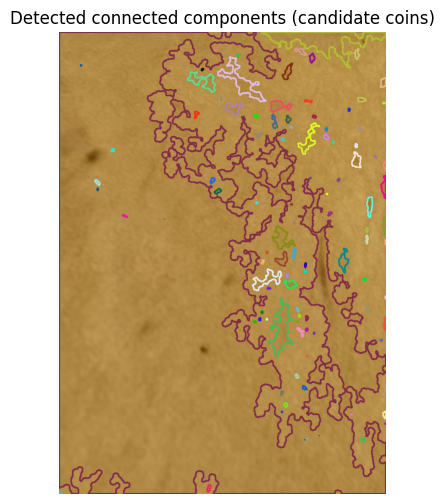

In [ ]:
# ================================================================
# 5.3 Connected components on the refined mask
# ================================================================

def find_connected_components(mask: np.ndarray):
    """
    Run connected-components analysis on a binary coin mask.

    Parameters
    ----------
    mask : np.ndarray
        Binary image (0 or 255) where coins are white.

    Returns
    -------
    num_labels : int
        Number of labels including background (label 0).
    labels : np.ndarray
        Label image with same height/width as mask.
    stats : np.ndarray
        Statistics for each label (x, y, width, height, area).
    centroids : np.ndarray
        (x, y) coordinates of the centroid of each label.
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    return num_labels, labels, stats, centroids


num_labels, labels, stats, centroids = find_connected_components(mask_refined)
print("Number of labels (including background):", num_labels)
print("Number of candidate coins:", num_labels - 1)  # label 0 is background

# --- Visualization: draw each component in a random color --------
# We draw on a copy of the rectified color image.
vis_components = img_rect_bgr.copy()

for label in range(1, num_labels):  # skip background
    component_mask = (labels == label).astype(np.uint8)

    # Find contour of this component
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        continue

    # Random color for visualization
    color = tuple(int(c) for c in np.random.randint(0, 255, size=3))
    cv2.drawContours(vis_components, contours, -1, color, thickness=2)

show(vis_components, "Detected connected components (candidate coins)")


### 5.4 Feature extraction and filtering (area + circularity)

The connected-components step found more regions than actual coins.
Some of these regions are tiny specks or slightly irregular blobs.

To keep only real coins, we:

1. Use the known **physical diameters** of Euro coins and the
   chosen `PIXELS_PER_MM` to derive an expected area range in pixels.
2. For each connected component we measure:
   - its pixel area,
   - an equivalent diameter (via the area),
   - a simple circularity measure.
3. We reject components that:
   - are too small or too large to be coins, or
   - are not round enough.

The result should be one component per physical coin, each with an
estimated diameter in millimetres.


In [ ]:
# ================================================================
# 5.4 Feature extraction and filtering (area + circularity)
# ================================================================

from dataclasses import dataclass

@dataclass
class CoinCandidate:
    """
    Container for measurements of a single connected component that
    is considered as a potential coin.
    """
    label: int
    area_px: int
    diameter_px: float
    diameter_mm: float
    circularity: float
    center: tuple[float, float]


def expected_area_range(px_per_mm: float) -> tuple[float, float]:
    """
    Compute a plausible pixel-area range for Euro coins based on
    their known physical diameters and the chosen pixels-per-mm.

    Parameters
    ----------
    px_per_mm : float
        Scale factor from millimetres to pixels used in the rectified image.

    Returns
    -------
    area_min : float
        Lower bound for the pixel area of a valid coin.
    area_max : float
        Upper bound for the pixel area of a valid coin.
    """
    # Use global EURO_MM dictionary defined earlier in the notebook.
    diameters = list(EURO_MM.values())
    d_min = min(diameters)
    d_max = max(diameters)

    def diameter_to_area_px(d_mm: float) -> float:
        r_px = 0.5 * d_mm * px_per_mm
        return np.pi * (r_px ** 2)

    area_min_physical = diameter_to_area_px(d_min)
    area_max_physical = diameter_to_area_px(d_max)

    # Add some tolerance to be robust against small errors.
    area_min = 0.5 * area_min_physical
    area_max = 1.5 * area_max_physical

    return area_min, area_max


# --- 1) Compute area thresholds from physics ---------------------
AREA_MIN, AREA_MAX = expected_area_range(PIXELS_PER_MM)
print(f"Expected area range: {AREA_MIN:.0f} .. {AREA_MAX:.0f} pixels")

# --- 2) Loop over components and measure properties --------------
coin_candidates: list[CoinCandidate] = []

for label in range(1, num_labels):  # skip background (label 0)
    x, y, w, h, area = stats[label]

    # Filter by area first (reject very small/large blobs)
    if area < AREA_MIN or area > AREA_MAX:
        continue

    # Build a mask for this component
    mask_label = (labels == label).astype(np.uint8)

    # Find contour for perimeter/circularity
    contours, _ = cv2.findContours(mask_label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        continue

    perimeter = cv2.arcLength(contours[0], True)
    circularity = 4.0 * np.pi * area / (perimeter ** 2 + 1e-8)

    # Filter by circularity (coins are close to circles)
    if circularity < 0.7:
        continue

    # Equivalent radius and diameter from area
    radius_px = np.sqrt(area / np.pi)
    diameter_px = 2.0 * radius_px
    diameter_mm = diameter_px / PIXELS_PER_MM

    # Centroid of this component
    cx, cy = centroids[label]

    coin_candidates.append(
        CoinCandidate(
            label=label,
            area_px=int(area),
            diameter_px=float(diameter_px),
            diameter_mm=float(diameter_mm),
            circularity=float(circularity),
            center=(float(cx), float(cy)),
        )
    )

print(f"Number of coin candidates after filtering: {len(coin_candidates)}")

# Display the measured candidates
for c in coin_candidates:
    print(
        f"label={c.label:2d} | "
        f"area={c.area_px:5d} px | "
        f"d = {c.diameter_mm:5.2f} mm | "
        f"circ = {c.circularity:4.2f}"
    )


Expected area range: 933 .. 7030 pixels
Number of coin candidates after filtering: 0


## 6. Classification into Euro coin types and total value

From the previous step we have a list of `coin_candidates`, each with:

- measured diameter in millimetres,  
- area in pixels,  
- circularity,  
- centroid position.

We now:

1. Define the true physical diameters and monetary values of Euro coins.
2. For each candidate, assign the **nearest Euro coin type** by diameter.
3. Compute the total value of all detected coins.
4. Visualize the classification result on the rectified A4 image.


Detected coins:

Total detected value: € 0.00


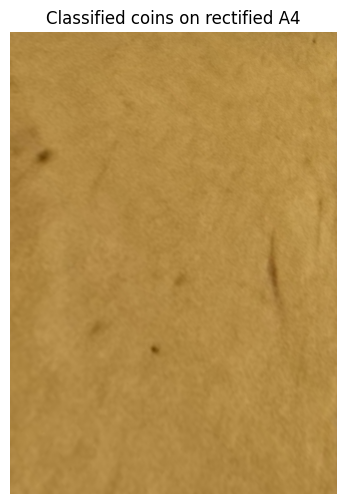

In [ ]:
# ================================================================
# 6. Classification into Euro coin types and total value
# ================================================================

# 6.1 Known Euro coin diameters and values ------------------------

# If you already defined EURO_MM and EURO_VAL earlier in the notebook,
# you can skip this block. Otherwise, this re-defines them for clarity.

EURO_MM = {
    "1c":  16.25,
    "2c":  18.75,
    "5c":  21.25,
    "10c": 19.75,
    "20c": 22.25,
    "50c": 24.25,
    "1€":  23.25,
    "2€":  25.75,
}

EURO_VAL = {
    "1c":  0.01,
    "2c":  0.02,
    "5c":  0.05,
    "10c": 0.10,
    "20c": 0.20,
    "50c": 0.50,
    "1€":  1.00,
    "2€":  2.00,
}


def classify_coin_by_diameter(d_mm: float) -> tuple[str, float]:
    """
    Classify a coin by comparing its measured diameter in millimetres
    to the known Euro coin diameters.

    Parameters
    ----------
    d_mm : float
        Measured diameter of the coin in millimetres.

    Returns
    -------
    coin_type : str
        The Euro coin type that best matches the measured diameter
        (e.g. '10c', '1€', ...).
    error_mm : float
        Absolute difference between measured diameter and the
        reference diameter of the chosen coin type.
    """
    best_type = None
    best_error = float("inf")

    for coin_type, ref_d in EURO_MM.items():
        error = abs(d_mm - ref_d)
        if error < best_error:
            best_error = error
            best_type = coin_type

    return best_type, best_error


# 6.2 Apply classification to all coin candidates -----------------

total_value = 0.0

for c in coin_candidates:
    coin_type, err_mm = classify_coin_by_diameter(c.diameter_mm)
    value = EURO_VAL[coin_type]

    total_value += value

    # Attach classification info to the dataclass instance
    c.type = coin_type          # dynamically add attribute
    c.error_mm = err_mm
    c.value_eur = value

print("Detected coins:")
for c in coin_candidates:
    print(
        f"{c.type:>3} | d_meas = {c.diameter_mm:5.2f} mm "
        f"(error = {c.error_mm:4.2f} mm) | value = {c.value_eur:4.2f} €"
    )

print(f"\nTotal detected value: € {total_value:.2f}")


# 6.3 Visualization: draw type labels on the rectified image ------

vis_class = img_rect_bgr.copy()

for c in coin_candidates:
    cx, cy = c.center
    # Draw a small circle at the centre
    cv2.circle(vis_class, (int(cx), int(cy)), 5, (0, 0, 255), -1)
    # Put the coin type text slightly above the centre
    cv2.putText(
        vis_class,
        c.type,
        (int(cx) - 20, int(cy) - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

show(vis_class, "Classified coins on rectified A4")


### 6.A Diameter calibration and robust classification

The previous classification step uses the raw measured diameters.
We observed a systematic scale error of a few percent, which leads
to wrong classes for coins with very similar sizes (e.g. 20c vs 1€
vs 50c).

Here we:

1. Apply a global calibration factor to all diameters.
2. Re-classify the coins using the corrected diameters.
3. Use alternative display labels (e.g. "1E", "2E") so that we do
   not depend on the Euro symbol in the plot.


Calibrated classification:

Total detected value (calibrated): € 0.00


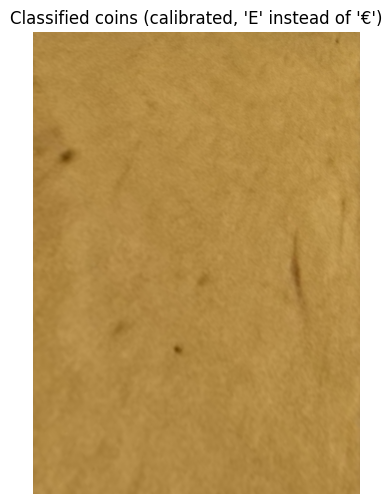

In [ ]:
# ================================================================
# 6.A Diameter calibration and robust classification
# ================================================================

def calibrate_diameter(d_mm: float, factor: float = 0.97) -> float:
    """
    Apply a global calibration factor to a measured diameter.

    Parameters
    ----------
    d_mm : float
        Measured diameter in millimetres.
    factor : float, optional
        Multiplicative correction factor. A value smaller than 1
        slightly reduces all diameters, compensating for systematic
        overestimation.

    Returns
    -------
    d_corr : float
        Calibrated (corrected) diameter in millimetres.
    """
    return d_mm * factor


CALIBRATION_FACTOR = 0.97  # based on comparing measured vs true diameters

# Mapping from internal coin type to a label string for plotting
DISPLAY_LABEL = {
    "1c": "1c",
    "2c": "2c",
    "5c": "5c",
    "10c": "10c",
    "20c": "20c",
    "50c": "50c",
    "1€": "1E",   # avoid '€' symbol in the plot
    "2€": "2E",
}

# --- Re-run classification with calibrated diameters -------------

total_value_calibrated = 0.0

for c in coin_candidates:
    # Correct the diameter
    d_corr = calibrate_diameter(c.diameter_mm, CALIBRATION_FACTOR)

    # Classify by corrected diameter
    coin_type, err_mm = classify_coin_by_diameter(d_corr)
    value = EURO_VAL[coin_type]

    # Store results on the candidate object (for later plotting)
    c.type_calib = coin_type
    c.diameter_mm_calib = d_corr
    c.error_mm_calib = err_mm
    c.value_eur_calib = value

    total_value_calibrated += value

print("Calibrated classification:")
for c in coin_candidates:
    print(
        f"{c.type_calib:>3} | "
        f"d_raw = {c.diameter_mm:5.2f} mm -> "
        f"d_cal = {c.diameter_mm_calib:5.2f} mm "
        f"(error = {c.error_mm_calib:4.2f} mm) | "
        f"value = {c.value_eur_calib:4.2f} €"
    )

print(f"\nTotal detected value (calibrated): € {total_value_calibrated:.2f}")


# --- Visualization with calibrated labels ------------------------

vis_class_calib = img_rect_bgr.copy()

for c in coin_candidates:
    cx, cy = c.center
    label_text = DISPLAY_LABEL[c.type_calib]

    # draw a dot at the centre
    cv2.circle(vis_class_calib, (int(cx), int(cy)), 5, (0, 0, 255), -1)

    # put label near the coin centre
    cv2.putText(
        vis_class_calib,
        label_text,
        (int(cx) - 20, int(cy) - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

show(vis_class_calib, "Classified coins (calibrated, 'E' instead of '€')")


## 7. Pipeline summary (from raw image to total value)

This section summarizes the complete processing chain implemented
in this notebook.

### 7.1 Geometry (A4 detection and rectification)

1. **Thresholding on the raw image**  
   - Convert to grayscale.  
   - Apply Gaussian blur.  
   - Use Otsu's method to separate the bright paper from the darker table.  

2. **Detect A4 sheet as largest quadrilateral**  
   - Find contours in the binary image.  
   - Keep external contours and approximate each with `cv2.approxPolyDP`.  
   - Select the largest convex quadrilateral as the A4 sheet.  

3. **Order the 4 corners and compute homography**  
   - Sort points into (top-left, top-right, bottom-right, bottom-left).  
   - Define the target rectangle with physical size 210 × 297 mm and a
     chosen resolution in pixels/mm.  
   - Compute homography `H` with `cv2.findHomography` and warp the image
     to a top-down view of the sheet (`cv2.warpPerspective`).  

### 7.2 Coin segmentation on the rectified sheet

4. **Blur + global threshold on rectified grayscale**  
   - Apply a stronger Gaussian blur (9×9) to suppress text and noise.  
   - Use global Otsu threshold with `THRESH_BINARY_INV` so that coins
     (dark) become white on a black background.  

5. **Morphological refinement**  
   - Use a small **opening** to remove tiny white speckles.  
   - Use a larger **closing** to fill small gaps and produce solid
     circular blobs for each coin.  

6. **Connected-components analysis**  
   - Run `connectedComponentsWithStats` on the refined binary mask.  
   - Each coin should correspond to exactly one connected component
     with its own area, centroid and bounding box.  

### 7.3 Measurement, calibration and classification

7. **Feature extraction and physical filtering**  
   - For each component:
     - read pixel area from `stats`,  
     - convert area to an equivalent diameter in pixels
       \\( d = 2 \\sqrt{A / \\pi} \\),  
     - convert diameter to millimetres using the pixels-per-mm value,  
     - compute circularity  
       \\( C = 4 \\pi A / P^2 \\).  
   - Reject components that:
     - are too small or too large compared to the smallest / largest
       Euro coin area (with a tolerance factor),  
     - have circularity below a threshold (not round enough).  

8. **Calibration of measured diameters**  
   - Due to small geometric and morphological effects, measured
     diameters are systematically a few percent too large.  
   - Apply a global calibration factor  
     \\( d_\mathrm{corr} = 0.97 \\, d_\mathrm{meas} \\)  
     derived from comparing measured diameters to the true Euro
     diameters.  

9. **Final classification and value computation**  
   - For each coin, find the Euro denomination whose true diameter is
     closest to the calibrated diameter.  
   - Use a lookup table to convert coin type (1c, 2c, …, 1€, 2€) to
     its monetary value.  
   - Sum all values to obtain the total amount of money in the image.  
   - Visualize the result by drawing the coin type near each centroid
     on the rectified A4 image.
